In [9]:
%autosave 60

Autosaving every 60 seconds


# Cancer Radiology Optimization

This Code Deals with Python Implimentation of the Paper [*Optimizing the Delivery of
Radiation Therapy to Cancer Patients* by David M Sheperd et. al. 1999](https://doi.org/10.1137/S0036144598342032) and then solving the problem given below using the Optimization Technique described in the above paper.

The Radiotherapy technique described in the above paper is also called as ***Tomotherapy***

Suppose we want to design an IMRT setup to obtain a dose corresponding to the following figure.

![Image](./images/tumor.png)



Assume that we want to achieve close to 10 units of radiation in the red region (denoting a tumor)
and be as much below 4 units as possible in the remaining portion. You may assume the radiation
intensity diminishes to half every 4 units (which means that this relation is not linear).
Assuming that each beam is 1 unit wide, find a suitable configuration of beam weights and angles
that can realize a plan as close as possible to the desired treatment. You may further assume that
each beam is composed of 20 small beamlets each of whose intensities can be controlled separately.
Solve one of the LPs or QPs proposed described by Shephard et al and find the optimal configuration.
Describe the configuration in a readable manner. Also draw a pictorial representation of
the intensity pattern achieved by your proposed solution. Comment on its quality. Clearly state
all your assumptions and choices of parameters.

### Assumptions
* All the beamlets are parallel
* Intensity in the Risk region hard constrained below 4
* 1 unit distance is divided into *grid_res* piece

## Control Parameters

In [10]:
#These parameters can be changed as required.

radi     =  3  #Radius of the circular organ region   
grid_sz  =  6  # Length of the grid square area (grid size)
grid_res = 20  # 1 unit length to be devided in grid_res Number of pizels per length
beamlets = 20  # Number of beamlets per beam. All the beamlets in a beam have same angle
pos      = 50  # Total angular positions of the beam setups


### The Equation Formulation used is as per the below section of the original paper


![Optimization Equation Formulation](./images/tumor_opti_equation.png)

#### Importing Dependencies

In [11]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
from math import exp
from amplpy import AMPL


#### Artificial parameters to be used derived from the ***user parameters*** above
Should Not be changed

In [12]:
#All length parameters will be multiplied with grid_res from hence forth
grid_sz *= grid_res
radi    *= grid_res
center   = (radi, radi)
# Get all angular positions    
positions = np.linspace(0, 360, num=pos, endpoint=False)


### Function for generating Dij_p matrix

Dij_p matrix is generated for each beamlet at each position. 

In [13]:
def GET_Dijp(angle, beamlet_no):
    """
    Beamlet Number starts at 0 to n-1 for n beamlets
    Returns a D_ij_p matrix
    """
    def IN_COL(coordinates):
        i = coordinates[0]; j = coordinates[1]
        res = grid_res
        if i>=(2.5+beamlet_no/20)*res and i<=(2.55+beamlet_no/20)*res:
            return(exp(-1*j/(4*grid_res)))
        else:
            return 0

    col = np.asarray([[IN_COL((i, j)) 
                        for i in range(grid_sz)] for j in range(grid_sz)])

    import scipy.ndimage.interpolation as inter
    col = inter.rotate(col, angle, reshape = False)
    return col

def IN_TUMOR(coordinates):
    """
    Uses 6x6 grid cordinates
    Returns: 1 if the passed cordinate is in tumor
    """
    i = coordinates[0]; j = coordinates[1]
    res = grid_res
    if i>=2.5*res and i<=3.5*res and j>=1*res and j<=5*res:
        return 1
    elif (((i>=1.5*res and i<=2.5*res) or(i>=3.5*res and i<=4.5*res)) and 
          ((j>=1*res and j<=2*res) or (j>=4*res and j<=5*res))):
        return 1
    else:
        return 0


### Map Risk zone and Tumor Zone in Matrix form


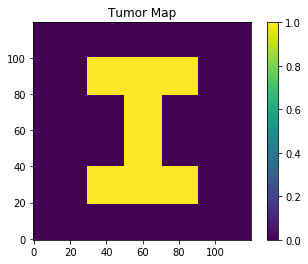

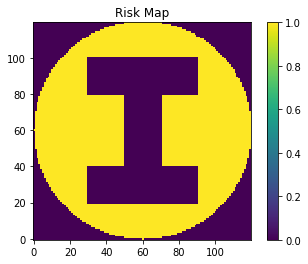

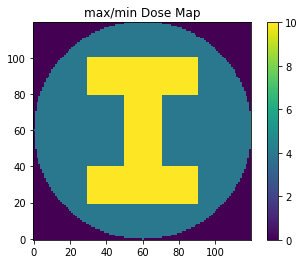

In [14]:
#Calculating Tumor Map and Risk Map
map_risk = np.asarray([[1 if dist.euclidean((i, j), center)<= radi else 0
                        for i in range(grid_sz)] for j in range(grid_sz)])
map_tumor = np.asarray([[IN_TUMOR((i, j)) 
                        for i in range(grid_sz)] for j in range(grid_sz)])
plt.imshow(map_tumor, origin='lower')
plt.colorbar()
plt.title('Tumor Map')
plt.show()
map_risk -= map_tumor

plt.imshow(map_risk, origin='lower')
plt.colorbar()
plt.title('Risk Map')
plt.show()
#Calculating Dose matrix
dose_risk = np.asarray([[4 if dist.euclidean((i, j), center)<= radi else 0
                        for i in range(grid_sz)] for j in range(grid_sz)])
dose_tumor= np.asarray([[10*IN_TUMOR((i, j)) 
                        for i in range(grid_sz)] for j in range(grid_sz)])

#
dose_tumor_temp= np.asarray([[4*IN_TUMOR((i, j)) 
                        for i in range(grid_sz)] for j in range(grid_sz)])    
dose_risk -= dose_tumor_temp #Substract 4 value dosage from tumor area

#Final Dose Requirements in One Matrix
#dose in risk region = 4; dose in tumor = 10
dose = dose_risk+dose_tumor
plt.imshow(dose, origin='lower')
plt.colorbar()
plt.title('max/min Dose Map')
plt.show()

In [15]:

#4D D_ijp [beam_position, beamlet, X, Y]
D_ijp = []
for beam_angle in positions:
    beam = [GET_Dijp(beam_angle, beamlet_no) for beamlet_no in range(beamlets)]
    D_ijp.append(beam)
D_ijp = np.asarray(D_ijp)

## AMPL API Code

In [16]:
"""
Optimization Code
"""
theta = [1, 0]
map_trn = [map_tumor, map_risk]
GRID_X = list(range(grid_sz))
GRID_Y = list(range(grid_sz))
BEAMLETS = list(range(beamlets))
POS = list(range(pos))
TRN = list(range(len(map_trn)))

ampl = AMPL()
import os
ampl.read(os.path.join('models', 'model_linear_norm.mod'))
ampl.getSet('GRID_X').setValues(GRID_X)
ampl.getSet('GRID_Y').setValues(GRID_Y)
ampl.getSet('TRN').setValues(TRN)
ampl.getSet('BEAMLETS').setValues(BEAMLETS)
ampl.getSet('POS').setValues(POS)

ampl.param['theta'] = theta
ampl.param['D_ijp'] = {
        (POS[p], BEAMLETS[b], GRID_X[x], GRID_Y[y]):D_ijp[p][b][x][y]
        for p in range(len(POS))
        for b in range(len(BEAMLETS))
        for x in range(len(GRID_X))
        for y in range(len(GRID_Y))
        }

ampl.param['d_ij'] = {
        (GRID_X[x], GRID_Y[y]):dose[x][y]
        for x in range(len(GRID_X))
        for y in range(len(GRID_Y))
        }

ampl.param['MAP_TRN'] = {
        (TRN[trn], GRID_X[x], GRID_Y[y]):map_trn[trn][x][y]
        for trn in range(len(TRN))
        for x   in range(len(GRID_X))
        for y   in range(len(GRID_Y))
        }

ampl.param['MAP_RISK'] = {
        (GRID_X[x], GRID_Y[y]):map_trn[1][x][y]
        for x   in range(len(GRID_X))
        for y   in range(len(GRID_Y))
        }

ampl.option['solver'] = 'gurobi'
ampl.solve()


Gurobi 7.5.0: optimal solution; objective 15687.3417
107 simplex iterations

"option rel_boundtol 9.088277083568741e-06;"
will change deduced dual values.



## Solution Starts Here

In [17]:
#Print the w values with their index
#print(ampl.var['w'].getValues().toPandas())


In [18]:
#Extrcting w values from the solution
w_values = ampl.var['w'].getValues()
w_values = list(w_values.getColumn('w.val'))
w_values = np.asarray(w_values).reshape(pos, beamlets)
#print(w_values)

In [19]:
#Shape of the transformed weight matrix.
w_values.shape

(50, 20)

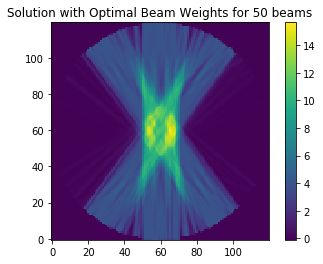

In [20]:

final_map = np.zeros((grid_sz, grid_sz))
for p in range(pos):
    for b in range(beamlets):
        final_map += w_values[p][b]*D_ijp[p][b]

img = plt.imshow(final_map, origin='lower')
plt.colorbar()
plt.title(f'Solution with Optimal Beam Weights for {pos} beams')
plt.show()